# Analyzing the JWST Pipeline products of HAT-P-1b observations with NIRISS/SOSS
--------------------------------------------------------------
**Author**: Néstor Espinoza (nespinoza@stsci.edu) | **Latest update**: July 6, 2020.

## Table of contents
1. [Introduction](#intro)
2. [Spectral extraction](#extraction)
   1. [Tracing the orders](#tracing)
   2. [Extracting the spectra](#extracting)
   3. [Time-stamps and wavelength solution](#timenwavelength)
3. [Fitting & analyzing white-light lightcurves](#white-light)
   1. [Studying the residuals](#wl-residuals)
4. [Fitting & analyzing the wavelength-dependant lightcurves](#wavelength)
5. [Studying the transit spectrum of HAT-P-1b](#transit-spectra)

1.<font color='white'>-</font>Introduction <a class="anchor" id="intro"></a>
------------------
In the previous notebooks, we simulated data for NIRISS/SOSS observations targeting a transit of HAT-P-1b, and calibrated the simulated data using the JWST pipeline. In this notebook, we analyze some of the products of the JWST pipeline in order to analyze the transmission spectrum of the exoplanet.
   
At the day of writing of this notebook, the JWST calibration pipeline does not have a spectral extraction algorithm that can deal with the complicated structure of NIRISS/SOSS data. In particular, the `SUBSTRIP256` subarray has data from at least two NIRISS/SOSS orders, which overlap at the reddest wavelengths. An algorithm to properly extract this data is on-the-making, but in this notebook we will be performing our own tracing and extraction of the spectra in order to showcase how to analyze the JWST products. After extracting the spectrum, we will generate the white-light lightcurves of each order, fit them and compare the extracted parameters to the ones in the literature. Then, we will repeat the procedures for the wavelength-dependant lightcurves, with which we will get the transmission spectrum of the exoplanet. 

Before we begin, let's import some libraries:

In [1]:
# General internal libraries:
import os
import numpy as np
import pickle
import matplotlib.pyplot as plt
from numpy.polynomial import chebyshev
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

# Libraries for plotting, reading data:
import seaborn as sns 
sns.set_style("ticks") # Set seaborn "ticks" style for better styled plots
from astropy.io import fits
from astropy.utils.data import download_file

# Useful library to obtain wavelength map solution from the JWST pipeline:
from jwst import datamodels

# Juliet (for transit fitting & model evaluation:)
import juliet

2.<font color='white'>-</font>Spectral extraction <a class="anchor" id="extraction"></a>
--------------------------------------------------------------------
### A.<font color='white'>-</font>Tracing the orders<a class="anchor" id="tracing"></a>
Before we can go ahead and perform spectral extraction of the orders, we need to trace them in order to guide the spectral extraction algorithm on where the spectrum is. Let's first do some data exploration to understand how we might do this with the complicated spectral profile of NIRISS/SOSS. Let's first extract the ramps from our previous notebook:

In [2]:
# In case user has not run the previous notebook, we download. the data_uncal.fits file which has the uncalibrated 
# simulated data:
if not os.path.exists('pipeline_outputs/step_LinearityStep_1_assignwcsstep.fits'):
    if not os.path.exists('pipeline_outputs'):
        os.mkdir('pipeline_outputs')
    file_path = download_file('https://data.science.stsci.edu/redirect/'+\
                              'JWST/jwst-data_analysis_tools/soss-transit-spectroscopy/'+\
                              'step_LinearityStep_1_assignwcsstep.fits')
    os.rename(file_path,'pipeline_outputs/step_LinearityStep_1_assignwcsstep.fits')
    
hdul_pipeline = fits.open('pipeline_outputs/step_LinearityStep_1_assignwcsstep.fits')
data = hdul_pipeline['SCI'].data
errors = hdul_pipeline['ERR'].data

There are several ways moving forward to trace the spectrum. In theory, when JWST is on the sky, precise shapes and positions will be available, and we could use those. Here, however, we will trace each integration individually, in order to check for possible movements/shape changes of the trace during the observations. Before doing this, however, let's generate a "median" image by collapsing all the products in time, so as to have a view of the "average" shape of the traces along the entire exposure:

In [3]:
median_image = np.median(data,axis=0)

Let's plot it:

Text(0, 0.5, 'Rates (Counts/s)')

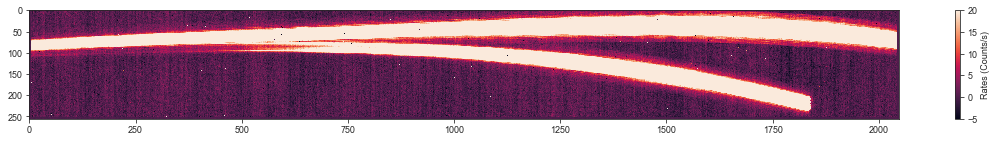

In [4]:
plt.figure(figsize=(20,2))
im = plt.imshow(median_image)
im.set_clim(-5,20)
cb = plt.colorbar()
cb.ax.set_ylabel('Rates (Counts/s)')

This plot tells us a lot about how to move forward with the data analysis in general of this dataset. For example, note that although the pipeline has done a good job at removing structure in the data, there is still some structure which appears as vertical strips. This is a well known pattern due to the readout of IR detectors which is typically identified as "1/f noise". By eye it seems some simple column-by-column background substraction should take care of that. On top of the tihs, this image tells us a little bit of the care we have to have with tracing. For example, spectra of order 1 and 2 start to overlap around pixel ~750. In addition, we can see how the right side of both traces are the ones that have the most signal, which decreases to the left-hand side (redder wavelengths) --- so if we do any kind of iterative tracing, we should perhaps start in those sides of the trace. Finally, it is important to note that the order in the bottom of this image (order 2) ends rather abruptly at around column 1750; this is actually a problem of the `awesimsoss` simulations and not a real feature of the NIRISS/SOSS traces. 

Let's use all of the above to our advantage to trace the spectra of each integration. First, let's write a small script to get the centroids of each column for each order on each integration. Here we'll use a very simple algorithm in which we convolve each column with a gaussian filter (in order to smooth the profile, which is rather complex), and then take the centroiding of that filtered image. We repeat this procedure in each of the columns of the image in order to obtain the centroids of the traces, and then we fit them with a polynomial:

In [5]:
from scipy.ndimage import gaussian_filter1d
def trace_spectrum(image, xstart, ystart, profile_radius = 20, gauss_filter_width = 10, xend = None):
    """
    Function that non-parametrically traces NIRISS/SOSS spectra. First, to get the centroid at xstart and 
    ystart, it convolves the spatial profile with a gaussian filter, finding its peak through usual flux-weighted 
    centroiding. Next, it uses a smoothed shape in this column to find the centroid of the next, left column, 
    through cross-correlation of that shape.
    
    Parameters
    ----------
    image: ndarray
        The image that wants to be traced.
    xstart: float
        The x-position (column) on which the tracing algorithm will be started
    ystart: float
        The estimated y-position (row) of the center of the trace. An estimate within 10-20 pixels is enough.
    profile_radius: float
        Expected radius of the profile measured from its center. Only this region will be used to estimate 
        the centroids of the spectrum.
    gauss_filter_width: float
        Width of the gaussian filter used to perform the centroiding of the first column
    xend: int
        x-position at which tracing ends. If none, trace all the columns left to xstart.
    """
    # Define x-axis:
    if xend is not None:
        x = np.arange(xend,xstart)
    else:
        x = np.arange(0,xstart)
    # Define y-axis:
    y = np.arange(image.shape[0])
    # Define array that will save centroids at each x:
    ycentroids = np.zeros(len(x))
    for i in range(len(x))[::-1]:
        xcurrent = x[i]
        # Convolve column with a gaussian filter; remove median before convolving:
        filtered_column = gaussian_filter1d(image[:,xcurrent] - np.median(image[:,xcurrent]), gauss_filter_width)
        # Find centroid within profile_radius pixels of the initial guess:
        idx = np.where(np.abs(y-ystart)<profile_radius)[0]
        ycentroids[i] = np.sum(y[idx]*filtered_column[idx])/np.sum(filtered_column[idx])
        ystart = ycentroids[i]
    # Check for nans:
    idx = np.where(~np.isnan(ycentroids))
    return x[idx],ycentroids[idx]

Let's try our algorithm first for order 1 (the one on the top). Let's start it on column 2043 which, by eye, has the center of the profile around pixel 70 in the median image. Let's do it for all integrations, and plot all of them on top of the median image to visually see our results:

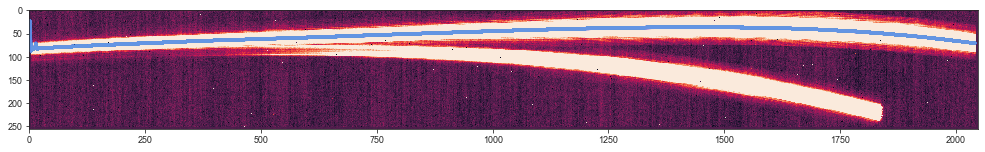

In [6]:
# Define variables for the tracing algorithm:
nintegrations = data.shape[0]
xstart = 2043
ystart = 70

# Prepare arrays that will save our results:
X1 = np.zeros([nintegrations, xstart])
Y1 = np.zeros([nintegrations, xstart])

# Prepare median image plot, on top of which we'll show the traces:
plt.figure(figsize=(17,12))
im = plt.imshow(median_image)
im.set_clim(-5,20)

# Iterate tracing through all integrations:
for i in range(nintegrations):
    X1[i,:],Y1[i,:] = trace_spectrum(data[i,:,:], xstart, ystart)
    plt.plot(X1[i,:],Y1[i,:],color='cornflowerblue',lw=3,alpha=0.1)

Woah, pretty good for such a simple approach! There are evidently some parts of the traces that go a bit off-board. In particular, the trace goes off at values below around 30. Let's fit a Chebyshev polynomial for each of them so we can smooth the shape a little bit, being carreful not to use these pixels that throw the trace off in the fit. To select the best order for this polynomial, let's write a small function that does model selection using the BIC for each trace, and then select the best order via "majority vote":

Best order was:  15


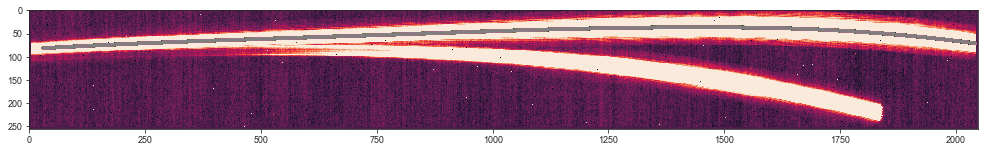

In [7]:
def select_cheby_order(x,y,min_order,max_order):
    """
    This function selects (and returns) the optimal order of a Chebyshev polynomial using the BIC.
    
    Parameters
    ----------
    x: ndarray
        Array with the regressors
    y: ndarray
        Array with the data
    min_order: int
        Minimum order to try
    max_order: int
        Maximum order to try
    """
    orders = np.arange(min_order,max_order)
    bics = np.zeros(len(orders))
    n = len(x)
    for i in range(len(orders)):
        order = orders[i]
        coeffs = chebyshev.chebfit(x,y,deg=order)
        RSS = np.sum((y - chebyshev.chebval(x,coeffs))**2)
        bics[i] = n*np.log(RSS/n) + (order+1)*np.log(n)
    idx = np.where(np.min(bics) == bics)[0]
    return orders[idx][0]

# Try orders from 1 to 30 in the polynomial for all the traces:
orders = np.zeros(nintegrations)
for i in range(nintegrations):
    orders[i] = select_cheby_order(X1[i,30:],Y1[i,30:],1,30)
# Select best order:
order = 15#int(np.median(orders))
print('Best order was: ',order)

# Use the best-one as deemed by the BIC to fit all the traces; plot them with median image on top:
plt.figure(figsize=(17,12))
im = plt.imshow(median_image)
im.set_clim(-5,20)
coeffs1 = np.zeros([nintegrations, order+1])
for i in range(nintegrations):
    coeffs1[i,:] = chebyshev.chebfit(X1[i,30:],Y1[i,30:],deg=order)
    plt.plot(X1[i,30:],chebyshev.chebval(X1[i,30:],coeffs1[i,:]),lw=3)

That's pretty good! 

Now, we can see how the same procedure is deemed to fail for order 2 (the lower trace) for columns below around 1000. This is because this order quickly starts to overlap with order 1 below this. We will help our algorithm a little bit then by masking the upper trace, and only fitting the trace for values above column 1000. To this end, we will use the same algorithm for obtaining the centroids of the trace but will pass a masked image, containing only the lower trace. To do this, we will multiply all the values below row 80 (i.e., the upper pixels in the plot above) by zero. 

We'll start our algorithm in column 1839 (the edge of the trace here), which has its centroid, by eye, around row 225. We also make sure to stop tracing for pixels smaller than 1000. Let's see how we do:

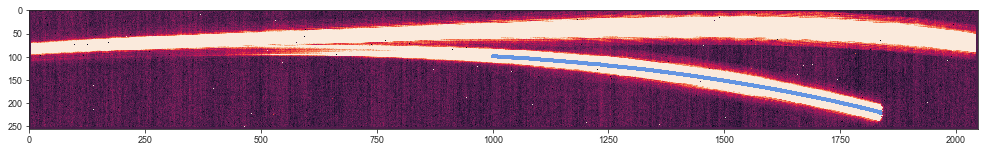

In [8]:
mask = np.zeros(median_image.shape)
mask[80:,:] = np.ones(mask[80:,:].shape)
xstart = 1839
ystart = 225
xend = 1000

# Prepare arrays that will save our results for order 2:
X2 = np.zeros([nintegrations, xstart-xend])
Y2 = np.zeros([nintegrations, xstart-xend])

# Prepare median image plot, on top of which we'll show the traces:
plt.figure(figsize=(17,12))
im = plt.imshow(median_image)
im.set_clim(-5,20)

# Iterate tracing through all integrations:
for i in range(nintegrations):
    X2[i,:],Y2[i,:] = trace_spectrum(data[i,:,:]*mask, xstart, ystart, xend = xend)
    plt.plot(X2[i,:],Y2[i,:],color='cornflowerblue',lw=3,alpha=0.1)

Pretty good! Let's smooth the trace, as done for Order 1, with a Chebyshev polynomial. Let's repeat the same procedure:

Best order was:  12


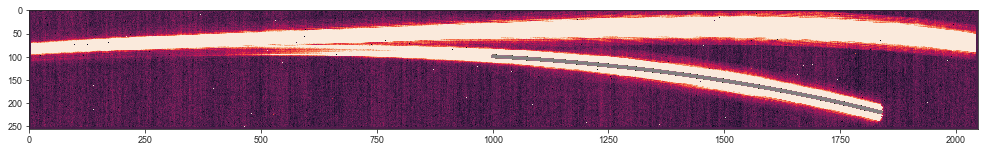

In [9]:
# Try orders from 1 to 30 in the polynomial for all the traces:
orders = np.zeros(nintegrations)
for i in range(nintegrations):
    orders[i] = select_cheby_order(X2[i,:],Y2[i,:],1,30)

# Select best order:
order = 12#int(np.median(orders))
print('Best order was: ',order)

# Use the best-one as deemed by the BIC to fit all the traces; plot them with median image on top:
plt.figure(figsize=(17,12))
im = plt.imshow(median_image)
im.set_clim(-5,20)
coeffs2 = np.zeros([nintegrations, order+1])
for i in range(nintegrations):
    coeffs2[i,:] = chebyshev.chebfit(X2[i,:],Y2[i,:],deg=order)
    plt.plot(X2[i,:],chebyshev.chebval(X2[i,:],coeffs2[i,:]),lw=3)

This looks great! Let's do a final plot showing the traces corresponding to the first integration on the median image:

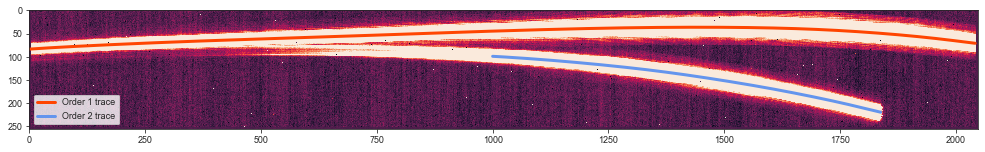

In [10]:
plt.figure(figsize=(17,12))
im = plt.imshow(median_image)
im.set_clim(-5,20)
plt.plot(X1[i,:],chebyshev.chebval(X1[i,:],coeffs1[0,:]),lw=3,label='Order 1 trace', color = 'orangered')
plt.plot(X2[i,:],chebyshev.chebval(X2[i,:],coeffs2[0,:]),lw=3,label='Order 2 trace', color = 'cornflowerblue')
plt.legend()

That's pretty good for such a simple procedure! 

How does the trace position change as a function of each integration? Was our integration-by-integration tracing really worthwile? Let's map this out using the location of the center of the trace as a proxy of the trace shift for each order:

(1, 1198)

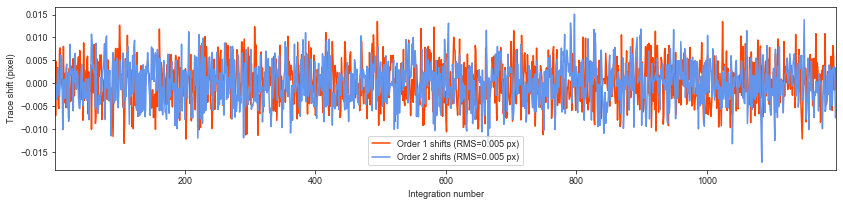

In [11]:
x1_median, y1_shift = np.median(X1), np.zeros(nintegrations)
x2_median, y2_shift = np.median(X2), np.zeros(nintegrations)
for i in range(nintegrations):
    y1_shift[i] =  chebyshev.chebval(x1_median,coeffs1[i,:])
    y2_shift[i] =  chebyshev.chebval(x2_median,coeffs2[i,:])
    
plt.figure(figsize=(14,3))
shift1 = y1_shift-np.median(y1_shift)
shift2 = y2_shift-np.median(y2_shift)
sigma_y1 = np.sqrt(np.var(shift1))
sigma_y2 = np.sqrt(np.var(shift2))
plt.plot(np.arange(nintegrations)+1,shift1,color='orangered',label=f'Order 1 shifts (RMS={round(sigma_y1,3)} px)')
plt.plot(np.arange(nintegrations)+1,shift2,color='cornflowerblue', label=f'Order 2 shifts (RMS={round(sigma_y2,3)} px)')
plt.legend()
plt.xlabel('Integration number')
plt.ylabel('Trace shift (pixel)')
plt.xlim([1,nintegrations])

It appears that the impact of the tracing in the case of the simulations is, indeed, _very_ small. The pixel shifts of the traces are about 1/200 of a pixel here. Consequently, at least in the simulations outlined here, we pressume these will not be a big impact on the retrieved lightcurves and transmission spectrum. 

### B.<font color='white'>-</font>Extracting the spectra<a class="anchor" id="extracting"></a>

With our traces at hand, in theory we can now perform simple extraction of the spectra on each integration. Before doing that, however, let's correct our images for the 1/f-noise patters on a column-by-column basis using the fact that we now know where the spectra is located, so we can mask the traces out of this procedure. 

To this end, for each image we will mask all the pixels in a 30-pixel radius around the traces (more or less the radius of the actual portion of the trace that contains flux from the target), and use the remaining pixels to track the column-to-column variations. Let's apply these corrections to the data:

In [12]:
# We will save the corrected data in a new array, as to keep track of the original dataset:
corrected_data = np.copy(data)
radius = 30
for i in range(nintegrations):
    for j in range(data.shape[2]):
        # Create mask that will turn to zero values not to be used for background estimation:
        mask = np.ones(data.shape[1])
        if j in X1[i,:]:
            y1 = int(chebyshev.chebval(j,coeffs1[i,:]))
            mask[y1-radius:y1+radius] = 0.
        if j in X2[i,:]:
            y2 = int(chebyshev.chebval(j,coeffs2[i,:]))
            mask[y2-radius:y2+radius] = 0.
        # Use only pixels that are not zero to calculate background through median:
        idx = np.where(mask != 0)[0]
        corrected_data[i,:,j] = corrected_data[i,:,j] - np.median(corrected_data[i,idx,j])

All right, let's now see how we did --- to this end, let's check the corrections made on the first integration:

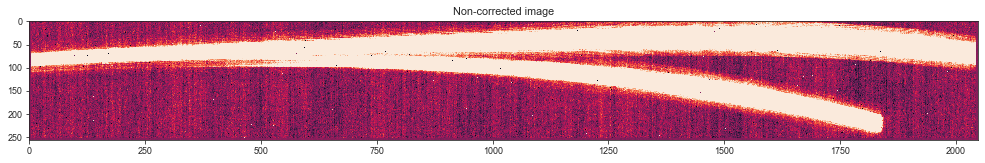

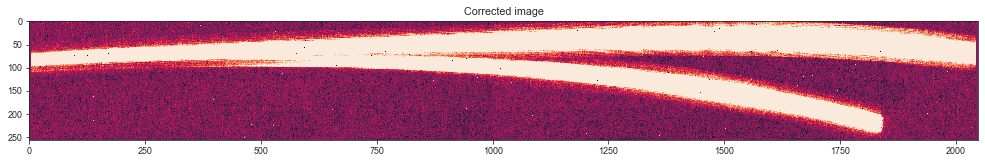

In [13]:
plt.figure(figsize=(17,12))
plt.title('Non-corrected image')
im = plt.imshow(data[0,:,:])
im.set_clim(-5,10)
plt.figure(figsize=(17,12))
plt.title('Corrected image')
im = plt.imshow(corrected_data[0,:,:])
im.set_clim(-5,10)

Much better! The strips observed in the original image have been corrected quite successfully thanks to our procedure. 

Let's now move forward and write a small script that is able to do simple aperture extraction given a set of `x` and `y` coordinates that follow the trace, and loop that through all of our integrations. In theory before doing this we would take care of bad pixels/cosmic rays, but we don't worry about this on this notebook because (a) cosmic rays have not been included in the simulations made to create this dataset and (b) bad pixels are the same on each image, so they don't impact any time-varying signal.

First, the aperture extraction function:

In [14]:
def aperture_extraction(image, x, y, aperture_radius, background_radius, error_image = None, correct_bkg = True):
    """
    This function takes as inputs two arrays (x,y) that follow the trace, 
    and returns the added flux over the defined aperture radius (and its error, if an error image 
    is given as well), substracting in the way any background between the aperture radius and the 
    background radius. The background is calculated by taking the median of the points between the 
    aperture_radius and the background_radius.
    
    Parameters
    ----------
    image: ndarray
        Image from which the spectrum wants to be extracted
    x: ndarray
        Array with the x-axis of the trace (i.e., the columns, wavelength direction)
    y: ndarray
        Array with the y-axis of the trace (i.e., rows, spatial direction)
    aperture_radius: float
        Distance from the center of the trace at which you want to add fluxes.
    background_radius: float
        Distance from the center of the trace from which you want to calculate the background. The 
        background region will be between this radius and the aperture_radius.
    error_image: ndarray
        Image with the errors of each pixel value on the image ndarray above
    correct_bkg: boolean
        If True, apply background correction. If false, ommit this.
    """
    # Create array that will save our fluxes:
    flux = np.zeros(len(x))
    if error_image is not None:
        flux_error = np.zeros(len(x))
    max_column = image.shape[0]
    for i in range(len(x)):
        # Cut the column with which we'll be working with:
        column = image[:,int(x[i])]
        if error_image is not None:
            variance_column = error_image[:,int(x[i])]**2
        # Define limits given by the aperture_radius and background_radius variables:
        if correct_bkg:
            left_side_bkg = np.max([y[i]-background_radius,0])
            right_side_bkg = np.min([max_column, y[i]+background_radius])
        left_side_ap = np.max([y[i]-aperture_radius,0])
        right_side_ap = np.min([max_column, y[i]+aperture_radius])
        # Extract background, being careful with edges:
        if correct_bkg:
            bkg_left = column[np.max([0,int(left_side_bkg)]):np.max([0,int(left_side_ap)])]
            bkg_right = column[np.min([int(right_side_ap),max_column]):np.max([int(right_side_bkg),max_column])]
            bkg = np.median(np.append(bkg_left,bkg_right))
        else:
            bkg = 0.
        # Substract it from the column:
        column -= bkg
        # Perform aperture extraction of the background-substracted column, being careful with pixelization 
        # at the edges. First, deal with left side:
        l_decimal, l_integer = np.modf(left_side_ap)
        l_integer = int(l_integer)
        if l_decimal < 0.5:
            l_fraction = (0.5-l_decimal)*column[l_integer]
            l_limit = l_integer+1
            if error_image is not None:
                l_fraction_variance = ((0.5-l_decimal)**2)*variance_column[l_integer]
        else:
            l_fraction = (1. - (l_decimal-0.5))*column[l_integer+1]
            l_limit = l_integer+2
            if error_image is not None:
                l_fraction_variance = ((1. - (l_decimal-0.5))**2)*variance_column[l_integer+1]
        # Now right side:
        r_decimal, r_integer = np.modf(right_side_ap)
        r_integer = int(r_integer)
        if r_decimal < 0.5:
            r_fraction = (1. - (0.5-r_decimal))*column[r_integer]
            r_limit = r_integer
            if error_image is not None:
                r_fraction_variance = ((1. - (0.5-r_decimal))**2)*variance_column[r_integer]
        else:
            r_fraction = (r_decimal-0.5)*column[r_integer+1]
            r_limit = r_integer+1
            if error_image is not None:
                r_fraction_variance = ((r_decimal-0.5)**2)*variance_column[r_integer+1]
        # Save total flux in current column:
        flux[i] = l_fraction + r_fraction + np.sum(column[l_limit:r_limit])
        if error_image is not None:
            # For the flux error, ommit edge values (contribution to total variance is small nonetheless):
            flux_error[i] = np.sqrt(np.sum(variance_column[l_limit:r_limit]) + l_fraction_variance + \
                                    r_fraction_variance)
    if error_image is not None:
        return flux, flux_error
    else:
        return flux

Let us now extract the spectra. To this end, we have to define an aperture extraction --- we decide to use a 10-pixel aperture extraction, and a 50-pixel background radius. As shown in the following plot, these regions cover both the spectra and also a big chunk of the background region(s): 

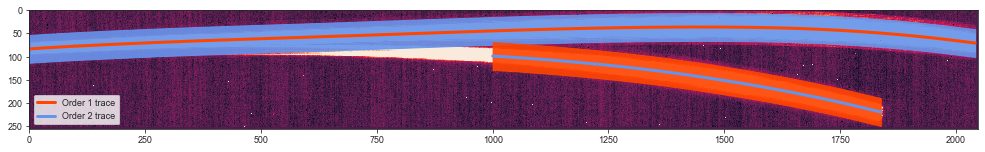

In [15]:
plt.figure(figsize=(17,12))
im = plt.imshow(median_image)
im.set_clim(-5,20)
plt.plot(X1[0,:],chebyshev.chebval(X1[0,:],coeffs1[0,:]),lw=3,label='Order 1 trace',color='orangered')
plt.plot(X2[0,:],chebyshev.chebval(X2[0,:],coeffs2[0,:]),lw=3,label='Order 2 trace',color='cornflowerblue')

plt.fill_between(X1[0,:],chebyshev.chebval(X1[0,:],coeffs1[0,:])+30,chebyshev.chebval(X1[0,:],coeffs1[0,:])-30,
                 color='cornflowerblue',alpha=0.9)
plt.fill_between(X2[0,:],chebyshev.chebval(X2[0,:],coeffs2[0,:])+30,chebyshev.chebval(X2[0,:],coeffs2[0,:])-30,
                 color='orangered',alpha=0.9)
plt.ylim(data.shape[1],0)
plt.legend()

Now let's loop over all the integrations, extract the spectra of both orders, and save that to some dictionaries. We note that this will take a while (around 10 minutes). We will save both the spectra and the columns, so we can later relate the latter to wavelength-space:

In [16]:
# Extraction parameters:
extraction_aperture = 30
background_aperture = 50

# Create dictionary:
spectra = {}
# Generate sub-dictionaries for each order:
spectra['order1'], spectra['order2'] = {}, {}
# Save the X positions for both orders. X positions are the same for all integrations, so 
# we save the ones corresponding to the first integration:
spectra['order1']['x'], spectra['order2']['x'] = X1[0,:], X2[0,:]
# Create sub-dictionaries that will save the fluxes and the errors on those fluxes:
spectra['order1']['flux'], spectra['order2']['flux'] = np.zeros([data.shape[0], len(X1[0,:])]),\
                                                       np.zeros([data.shape[0], len(X2[0,:])])

spectra['order1']['flux_errors'], spectra['order2']['flux_errors'] = np.zeros([data.shape[0], len(X1[0,:])]),\
                                                                     np.zeros([data.shape[0], len(X2[0,:])])

# Now iterate through all integrations:
for i in range(nintegrations):
    # Trace order 1:
    y1 = chebyshev.chebval(X1[0,:],coeffs1[i,:])
    # Extract order 1:
    spectra['order1']['flux'][i,:], spectra['order1']['flux_errors'][i,:] = \
                                                         aperture_extraction(corrected_data[i,:,:], X1[0,:], y1, \
                                                         extraction_aperture, background_aperture, \
                                                         error_image = errors[i,:,:])
    # Same for Order 2:
    y2 = chebyshev.chebval(X2[0,:],coeffs2[i,:])
    spectra['order2']['flux'][i,:], spectra['order2']['flux_errors'][i,:] = \
                                                         aperture_extraction(corrected_data[i,:,:], X2[0,:], y2, \
                                                         extraction_aperture, background_aperture, \
                                                         error_image = errors[i,:,:])

Finally, let's plot the spectra of the first integration along with the errorbars:

Text(0, 0.5, 'Counts/s')

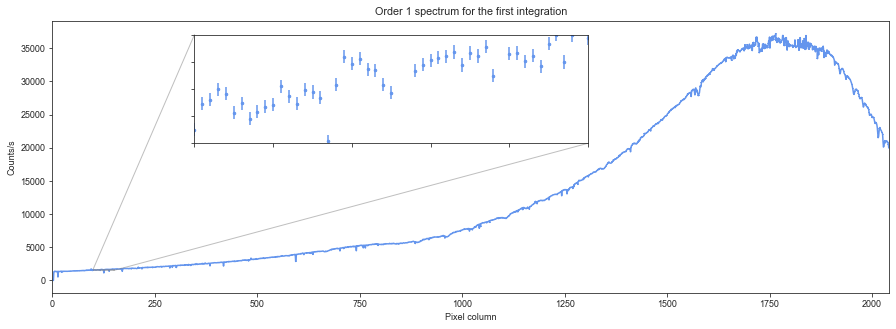

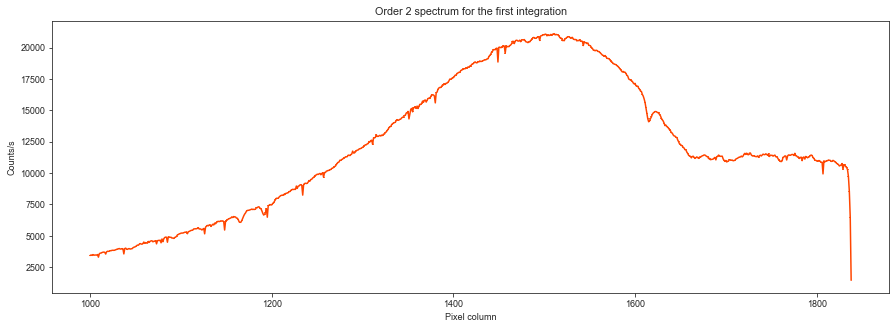

In [17]:
i = 0
fig, ax = plt.subplots(figsize=(15,5))
ax.set_title('Order 1 spectrum for the first integration')
ax.errorbar(spectra['order1']['x'], spectra['order1']['flux'][i,:], \
             yerr = spectra['order1']['flux_errors'][i,:], color = 'cornflowerblue')
# Plot inset to actually see errorbars:
axins = ax.inset_axes([0.17, 0.55, 0.47, 0.4])
x1, x2, y1, y2 = 100,150, 1500, 1700
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.set_xticklabels('')
axins.set_yticklabels('')
axins.errorbar(spectra['order1']['x'], spectra['order1']['flux'][i,:], \
             yerr = spectra['order1']['flux_errors'][i,:], fmt='.', color = 'cornflowerblue')
ax.set_xlim(np.min(spectra['order1']['x']),np.max(spectra['order1']['x']))

ax.indicate_inset_zoom(axins)
ax.set_xlabel('Pixel column')
ax.set_ylabel('Counts/s')

plt.figure(figsize=(15,5))
plt.title('Order 2 spectrum for the first integration')
plt.errorbar(spectra['order2']['x'], spectra['order2']['flux'][i,:], \
             yerr = spectra['order2']['flux_errors'][i,:], color = 'orangered')
plt.xlabel('Pixel column')
plt.ylabel('Counts/s')

This is pretty good! It is interesting to see how we can actually identify where the contamination from the second order kicks in in the Order 1 spectra (blue) around pixel ~750. This is actually evident from the images above, and something to keep in mind when performing analyses with this data. 

**[Developer note: the flattening of the spectral shape for pixels above ~1700 in Order 2 is most likely a bug from the awesimsoss simulator. We'll be working to fix this.]**

### C.<font color='white'>-</font>Time-stamps and wavelength solution<a class="anchor" id="timenwavelength"></a>

Before continuing to the next step, we need to extract two extra data products that will become useful in our analyses in this notebook: (a) the time-stamps of each integration and (b) the wavelength solution corresponding to each pixel in the frame for Order 1 and Order 2. 

The first is the easiest to extract --- these will be typically stored as a data product in our ramps, and in real JWST observations should be obtained by doing, in our case, `hdul_pipeline['INT_TIMES'].data['int_mid_BJD_TDB']` (where `hdul_pipeline` is the HDU List of the pipeline products that we loaded in the second cell of this notebook). Here, these have not been populated because our data come from simple simulations and not real observations --- we have, however, stored the time-stamps for _each frame_ in the first notebook in a numpy array, that we will be loading here. We average those over each integration below:

In [18]:
# If user didn't run the previous notebooks, no problem, download the timestamps:
if not os.path.exists('times.npy'):
    file_path = download_file('https://data.science.stsci.edu/redirect/'+\
                              'JWST/jwst-data_analysis_tools/soss-transit-spectroscopy/times.npy')
    t = np.load(file_path)
else:
    t = np.load('times.npy')
spectra['times'] = np.mean(t.reshape(-1, 3), axis=1)

As for the wavelength solution, as was already shown in the previous notebook, these have been attached to our dataset thanks to the `assign_wcs` step of the JWST pipeline. Let's extract those wavelength maps here for Order 1 and Order 2 (this will take a while):

In [19]:
exposure = datamodels.SpecModel('pipeline_outputs/step_LinearityStep_1_assignwcsstep.fits')
# Get number of rows and columns on the first integration:
rows,columns = corrected_data[0,:,:].shape
# Prepare map that will save the wavelength corresponding to each pixel in the frame:
wmap = np.zeros([2,rows,columns])
# Save it:
for order in [1,2]:
    for row in range(rows):
        for column in range(columns):
            wmap[order-1,row,column] = exposure.meta.wcs(column, row, order)[-1]

One important caveat to have in mind is that the wavelength maps are not strictly vertical, i.e., wavelengths do not align perfectly with the columns of the image for NIRISS/SOSS observations. An easy way to see this is to have an image showing "iso-wavelength" bands --- identify pixels that have the same wavelengths and "paint" them in a plot. Let's do this for Order 1:

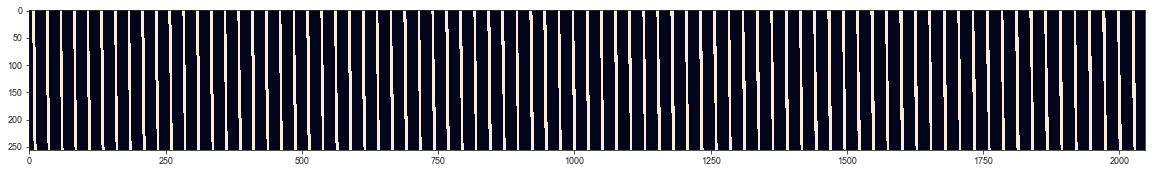

In [20]:
plt.figure(figsize=(20,25))
Z = np.zeros(wmap[0,:,:].shape)
for w in np.linspace(0.5,3.,100):
    wmin,wmax = w,w+0.005
    idx = (wmap[0,:,:]>wmin)&(wmap[0,:,:]<wmax)
    Z[idx] = 1.
plt.imshow(Z,interpolation=None)

As can be seen from these maps, this is not extremely critical for NIRISS/SOSS (iso-wavelength bands span ~3-5 pixels), but it might be important for precise, higher-resolution work to take this into account in the extraction. For our application here, however, we simply take the average wavelength value per column to associate wavelengths with pixels for each order, and we save that to our dictionary:

In [21]:
avg_waves = np.mean(wmap,axis=1)
spectra['order1']['w'], spectra['order2']['w'] = avg_waves[0,spectra['order1']['x'].astype('int')],\
                                                 avg_waves[1,spectra['order2']['x'].astype('int')]  

Let's have a final look at the extracted spectra of the first 100 integrations, but now with these wavelengths as x-axis instead of the pixel columns:

Text(0, 0.5, 'Counts/s')

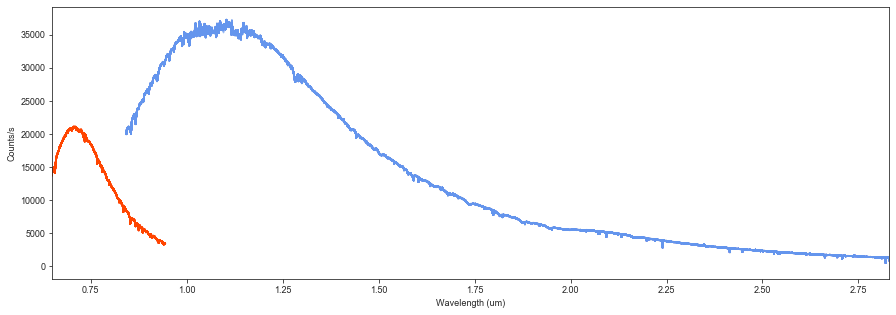

In [22]:
plt.figure(figsize=(15,5))
for i in range(100):
    plt.plot(spectra['order1']['w'], spectra['order1']['flux'][i,:], color = 'cornflowerblue',alpha = 0.5)
    plt.plot(spectra['order2']['w'], spectra['order2']['flux'][i,:], color = 'orangered',alpha = 0.5)
plt.xlabel('Wavelength (um)')
plt.xlim([0.65,2.83])
plt.ylabel('Counts/s')

That looks pretty good! Having our completed/reduced dataset, we proceed to save our pickle file in order to keep working with this in the next sections:

In [23]:
pickle.dump(spectra, open('spectra.pkl','wb'))

**[Developer note: on the final iteration of this notebook, these pickle dumps should be removed]**

3.<font color='white'>-</font>Fitting & analyzing white-light lightcurves<a class="anchor" id="white-light"></a>
---------------------------------------------------------------------------------------

Having extracted our spectra, we are ready to jump into the "fun" part of this notebook: the analyses of actual simulated NIRISS/SOSS transit lightcurves. Let's first create the white-light lightcurves of both Order 1 and Order 2 by summing the spectra extracted in the previous section, but on regions on which we *know* there will be _no_ contamination from overlapping orders. This step is important because the white-light lightcurves help determine the most precise transit parameters for the wavelength-dependant lightcurves, and thus we want to have estimates that are as unbiased as possible.

From the figures above, it seems that for Order 1 pixels below around 300 and above 1300 have virtually no contamination from Order 2. For Order 2, fluxes from pixels above around 1300 also have virtually no contamination from Order 1. Let's generate the corresponding lightcurves taking that into account:


(<mpl_toolkits.axes_grid1.inset_locator.BboxPatch at 0x7f86d8bcd978>,
 <mpl_toolkits.axes_grid1.inset_locator.BboxConnector at 0x7f86d8bcdfd0>)

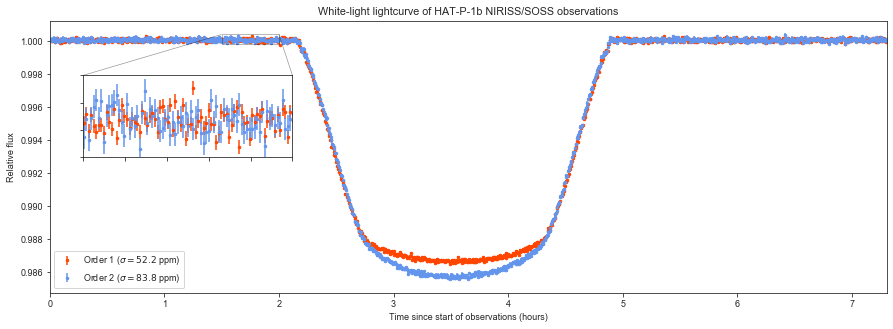

In [24]:
# Load spectra:
spectra = pickle.load(open('spectra.pkl','rb'))

# Extract order 1 length, create array that will save white-light lightcurve (and errors): 
NT1 = spectra['order1']['flux'].shape[0]
lc_order1 = np.zeros(NT1)
lc_errors_order1 = np.zeros(NT1)

# Same for order 2:
NT2 = spectra['order2']['flux'].shape[0]
lc_order2 = np.zeros(NT2)
lc_errors_order2 = np.zeros(NT2)

# Indexes of uncontaminated spectra for Order 1 and 2:
idx_uncontaminated1 = np.where((spectra['order1']['x'] < 300)|(spectra['order1']['x'] > 1300))[0]
idx_uncontaminated2 = np.where(spectra['order2']['x']  > 1300)[0]

# Sum the fluxes and errors for each order. First, order 1:
for i in range(NT1):
    lc_order1[i] = np.sum(spectra['order1']['flux'][i,idx_uncontaminated1])
    lc_errors_order1[i] = np.sqrt(np.sum(spectra['order1']['flux_errors'][i,idx_uncontaminated1]**2))
    
# Now order 2:
for i in range(NT2):
    lc_order2[i] = np.sum(spectra['order2']['flux'][i,idx_uncontaminated2])
    lc_errors_order2[i] = np.sqrt(np.sum(spectra['order2']['flux_errors'][i,idx_uncontaminated2]**2))

# Save median-normalized lightcurves and errors:
median_lc1, median_lc2 = np.median(lc_order1), np.median(lc_order2)
spectra['order1']['white-light'] = lc_order1/median_lc1
spectra['order1']['white-light_errors'] = lc_errors_order1/median_lc1
spectra['order2']['white-light'] = lc_order2/median_lc2
spectra['order2']['white-light_errors'] = lc_errors_order2/median_lc2
# Write median errors in ppm:
med_err_order1 = np.median(spectra['order1']['white-light_errors'])*1e6
med_err_order2 = np.median(spectra['order2']['white-light_errors'])*1e6

# Save variable with times in units of hours since beggining of observation:
thours = (spectra['times']-spectra['times'][0])*24

# Plot lightcurve
fig, ax = plt.subplots(figsize=(15,5))
ax.set_title('White-light lightcurve of HAT-P-1b NIRISS/SOSS observations')

ax.errorbar(thours,spectra['order1']['white-light'],yerr=spectra['order1']['white-light_errors'], \
             color='orangered',fmt='.',label=f'Order 1 ($\sigma={round(med_err_order1,1)}$ ppm)')
ax.errorbar(thours,spectra['order2']['white-light'],yerr=spectra['order2']['white-light_errors'], \
             color='cornflowerblue',fmt='.',label=f'Order 2 ($\sigma={round(med_err_order2,1)}$ ppm)')

# Define legend, limits, labels:
ax.legend()
ax.set_xlim(np.min(thours),np.max(thours))
ax.set_xlabel('Time since start of observations (hours)')
ax.set_ylabel('Relative flux')

# Plot inset to see errorbars:
axins = ax.inset_axes([0.04, 0.5, 0.25, 0.3])
x1, x2, y1, y2 = 1.5, 2.0, 0.9998,1.0004
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.set_xticklabels('')
axins.set_yticklabels('')
axins.errorbar(thours,spectra['order1']['white-light'],yerr=spectra['order1']['white-light_errors'], \
             color='orangered',fmt='.')
axins.errorbar(thours,spectra['order2']['white-light'],yerr=spectra['order2']['white-light_errors'], \
             color='cornflowerblue',fmt='.')

mark_inset(ax, axins, loc1=1, loc2=2, linewidth=0.7, fc="None", ec='k', alpha=0.4, clip_on=True, zorder=3)

Wow! Those look pretty good. There is a notable difference in the minimum fluxes here. Part of it can be attributed to limb-darkening (being Order 1 the order covering the reddest wavelengths, limb-darkening produces a more "box-shaped" lightcurve than for Order 2) --- but a portion of it could also be explained by the transit depths themselves.

Let's now fit those transit lightcurves. We will fit them separately to see what we obtain from each order, compare and discuss the results. To perform the transit fitting, users can of course use any tool they want. In this notebook, we will use `juliet` (http://juliet.readthedocs.io/), which is a tool that allows to perform lightcurve fitting through Nested Sampling algorithms, so we can thoroughly explore the parameter space. 

We first import `juliet` and write the priors for the parameters of our fit. We will leave the period, $P$ (`P_p1`) of the orbit fixed. The parameters we will be fitting for are the time-of-transit center $t_0$ (`t0_p1`), two parameters that parametrize the planet-to-star radius ratio $R_p/R_*$ and the impact parameter of the orbit $b = (a/R_*)\cos i$ in a unitary uniform plane, $r_1$ (`r1_p1`) and $r_2$ (`r2_p1` --- see [Espinoza (2018)](https://iopscience.iop.org/article/10.3847/2515-5172/aaef38/meta) for details), two parameters that parametrize the limb-darkening through a quadratic limb-darkening law, $q_1$ (`q1_SOSS`) and $q_2$ (`q2_SOSS` --- see [Kipping (2013](https://ui.adsabs.harvard.edu/abs/2013MNRAS.435.2152K/abstract)), the stellar density $\rho_*$ (`rho`), a scaling normalization factor for the out-of-transit flux (`mflux_SOSS`) and an unknown standard deviation added in quadrature to the errorbars of our data, `sigma_w_SOSS`. On top of this, we fix some parameters in our fit as well: we don't fit for the eccentricity $e$ (`ecc_p1`) or argument of periastron passage $\omega$ (`omega_p1`), as a single transit does not hold much information on these parameters. Similarly, we fix any possible dilution of the transit lightcurve by background sources (`mdilution_SOSS`) to 1, so we assume no dilution is in place. We take very wide priors for all the parameters that are left as free parameters in our fit except for the period, which we assume is well-known:

In [25]:
# Name of the parameters to be fit:
params = ['P_p1','t0_p1','r1_p1','r2_p1','q1_SOSS','q2_SOSS','ecc_p1','omega_p1',\
              'rho', 'mdilution_SOSS', 'mflux_SOSS', 'sigma_w_SOSS']

# Distributions:
dists = ['fixed','normal','uniform','uniform','uniform','uniform','fixed','fixed',\
                 'loguniform', 'fixed', 'normal', 'loguniform']

# Hyperparameters
hyperps = [4.4652998, [2456114.3,0.1], [0.,1], [0.,1.], [0., 1.], [0., 1.], 0.0, 90.,\
                   [100., 10000.], 1.0, [0.,0.1], [0.1, 1000.]]

priors = juliet.generate_priors(params,dists,hyperps)

Having defined the parameters, priors and the hyperparameters of those priors, we now fit both datasets. For this, we pass the data in a `juliet`-friendly format, and fit each transit individually:

In [26]:
for order in ['order1','order2']:
    # Define times, fluxes and errors in a juliet-friendly format:
    times, fluxes, fluxes_error, norm_times = {},{},{}, {}
    times['SOSS'], fluxes['SOSS'], fluxes_error['SOSS'] = spectra['times'],\
                                                          spectra[order]['white-light'],\
                                                          spectra[order]['white-light_errors']
    
    # Load and fit dataset with juliet (save them to order*_juliet_results):
    spectra[order]['dataset'] = juliet.load(priors=priors, t_lc = times, y_lc = fluxes,\
                                yerr_lc = fluxes_error, out_folder = order+'_juliet_results')

    spectra[order]['results'] = spectra[order]['dataset'].fit(use_dynesty = True, dynamic = True, dynesty_nthreads=4)

69742it [27:06, 17.81it/s, batch: 5 | bound: 701 | nc: 25 | ncall: 2542275 | eff(%):  2.743 | loglstar: 9588.747 < 9595.697 < 9594.079 | logz: 9542.427 +/-  0.314 | stop:  0.921]             
66126it [29:59, 29.37it/s, batch: 5 | bound: 844 | nc: 25 | ncall: 3260841 | eff(%):  2.028 | loglstar: 9509.565 < 9516.741 < 9514.810 | logz: 9466.310 +/-  0.304 | stop:  0.968]             


Let's see how the fits look like:

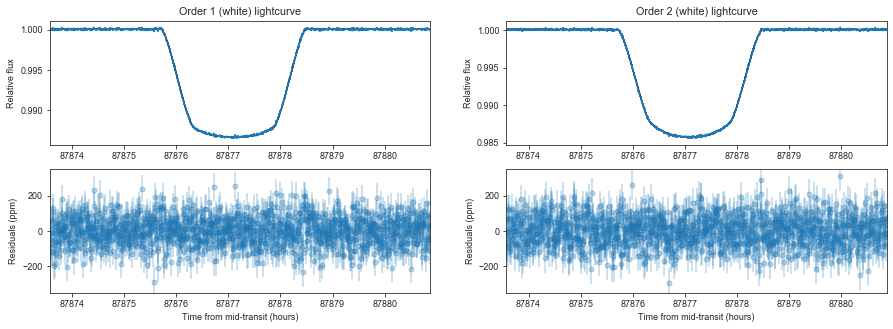

In [27]:
plt.figure(figsize=(15,5)) 

for i in [1,2]:
    plt.subplot('22'+str(i))
    plt.title('Order '+str(i)+' (white) lightcurve')
    order = 'order'+str(i)
    # First, extract estimated additional errorbars form our fits:
    sigma_w = np.median(spectra[order]['results'].posteriors['posterior_samples']['sigma_w_SOSS'])
    spectra[order]['sigma_w'] = sigma_w
    # Extract estimated time-of-transit center:
    t0 = np.median(spectra[order]['results'].posteriors['posterior_samples']['t0_p1'])
    # Normalize times to plot by this:
    tnorm = (spectra['times']-t0)*24
    plt.errorbar(tnorm, spectra[order]['white-light'], \
                 yerr = np.sqrt(spectra[order]['white-light_errors']**2 + (sigma_w*1e-6)**2), \
                 label='Data')
    # Plot best-fit model on top:
    spectra[order]['model'] = spectra[order]['results'].lc.evaluate('SOSS')
    plt.plot(tnorm, spectra[order]['model'],color='black',label='Model')
    plt.xlim(np.min(tnorm),np.max(tnorm))
    plt.ylabel('Relative flux')
    # Residuals:
    plt.subplot('22'+str(i+2))
    spectra[order]['residuals'] = spectra[order]['white-light'] - spectra[order]['model']
    plt.errorbar(tnorm, spectra[order]['residuals']*1e6, \
                 yerr = np.sqrt(spectra[order]['white-light_errors']**2 + (sigma_w*1e-6)**2)*1e6, \
                 fmt='o',alpha=0.3)
    plt.xlim(np.min(tnorm),np.max(tnorm))
    plt.ylim(-350,350)
    average_total_errorbar = np.median(np.sqrt(spectra[order]['white-light_errors']**2 + (sigma_w*1e-6)**2)*1e6)
    #print(average_total_errorbar)
    #plt.text(1,220,r'$\sigma_w = {0:.1f}$ ppm'.format(average_total_errorbar),fontsize=13)
    plt.ylabel('Residuals (ppm)')
    plt.xlabel('Time from mid-transit (hours)')

Those look pretty good! The precisions more or less match what is expected from NIRISS/SOSS white-light lightcurves. 

### A.<font color='white'>-</font>Studying the residuals<a class="anchor" id="wl-residuals"></a>

One might wonder if there is any structure in the residuals. This structure can give rise to signals that, if not accounted for, might led us to believe we have a precision that is much better that what the dataset actually has to offer. A classic approach to performing a quick check on the residuals is to see if, as you bin more datapoints, their rms decreases with the square-root of the number of datapoints. If the data is distributed as gaussian random noise, then one should see a $1/\sqrt{N}$ decline in this plot, where $N$ is the number of datapoints in a given bin. This is an easy check to make in this case:

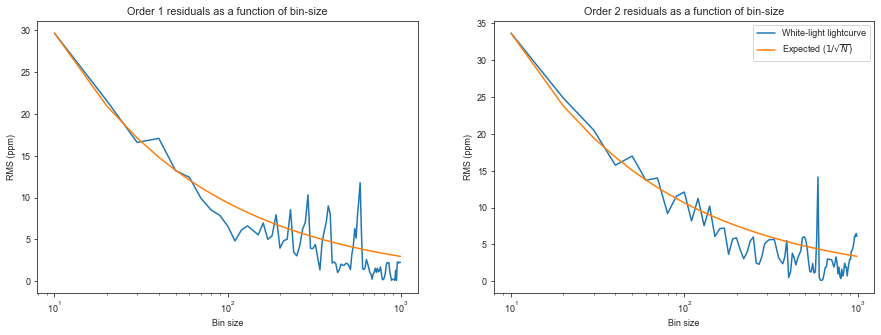

In [28]:
plt.figure(figsize=(15,5))

bin_sizes = np.arange(10,1000,10)
for i in [1,2]:
    order = 'order'+str(i)
    plt.subplot('12'+str(i))
    plt.title('Order '+str(i)+' residuals as a function of bin-size')
    rms = np.zeros(len(bin_sizes))
    for j in range(len(bin_sizes)):
        bin_size = bin_sizes[j]
        binned_times, binned_residuals, binned_errors = juliet.utils.bin_data(spectra['times'],\
                                                                              spectra[order]['residuals'],\
                                                                              bin_size)
        rms[j] = np.sqrt(np.var(binned_residuals))*1e6
    plt.plot(bin_sizes,rms,label='White-light lightcurve')
    plt.plot(bin_sizes,(np.sqrt(bin_sizes[0])*rms[0])/np.sqrt(bin_sizes),label='Expected ($1/\sqrt{N}$)')
    plt.xscale('log')
    plt.ylabel('RMS (ppm)')
    plt.xlabel('Bin size')
plt.legend()

In all honesty, the plots are not _that_ clear. The data (especially the one from Order 1) seems to go slightly below this $\sqrt{N}$ line, with some peaks at certain bin-sizes in which they go above it. It is unclear if these peaks say something meaningful or not. We turn, thus, to a second way of studying the residuals, which is always _my_ preferred way of studying them: analyzing the power spectrum of the residuals. This basically transforms the time-series to Fourier space where we can actually see if there is any evidence for residual signals at different time-scales/frequencies:

Maximum power: 0.0111, frequency: 50.71, FAP: 100.00%
Maximum power: 0.0111, frequency: 45.85, FAP: 100.00%


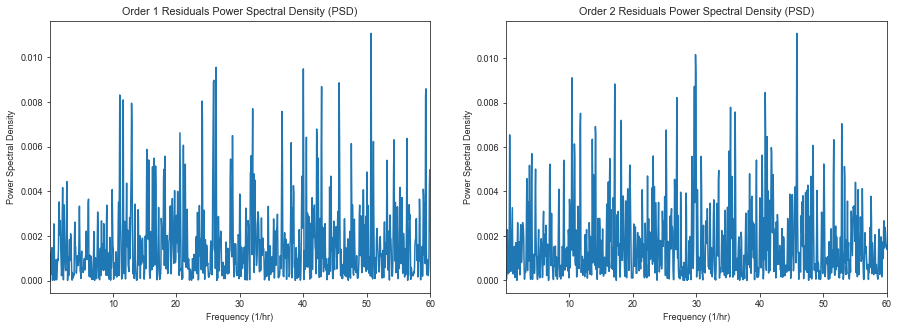

In [29]:
plt.figure(figsize=(15,5)) 

from astropy.timeseries import LombScargle
# Define frequencies in hours. From more or less the duration of the observation (~1 over 10 hours) to the 
# time-sampling (~1 over 1 minute, so over 1/60 hours)
frequency = np.linspace(1./10.,1./(1./60.), 1000)

for i in [1,2]:
    order = 'order'+str(i)
    plt.subplot('12'+str(i))
    plt.title('Order '+str(i)+' Residuals Power Spectral Density (PSD)')
    ls = LombScargle((spectra['times']-spectra['times'][0])*24, spectra[order]['residuals'])
    psd = ls.power(frequency)
    max_power = np.max(psd)
    max_freq = frequency[np.where(max_power == psd)[0]][0]
    fap = ls.false_alarm_probability(max_power) 
    print('Maximum power: {0:.4f}, frequency: {1:.2f}, FAP: {2:.2f}%'.format(max_power,max_freq,fap*100))
    plt.plot(frequency,psd)
    plt.ylabel('Power Spectral Density')
    plt.xlabel('Frequency (1/hr)')
    plt.xlim([1./10.,60.])

This looks fairly good! There is apparently no clear peak in these power spectral densities, with peaks evenly distributed across all frequencies --- i.e., the noise pattern appears to be fairly "white". We thus move ahead with that hypothesis, and assume there is no residual signal and/or correlated noise in our fits left to model.

4.<font color='white'>-</font>Fitting & analyzing the wavelength-dependant lightcurves<a class="anchor" id="wavelength"></a>
---------------------------------------------------------------------------------------


One of the main products that ought to be analyzed when observing transits with JWST are the wavelength-dependant lightcurves. Fitting those lets us obtain the final product of our observations: its transmission spectrum. To retrieve this, let us first fit the wavelength dependant lightcurves for each order:

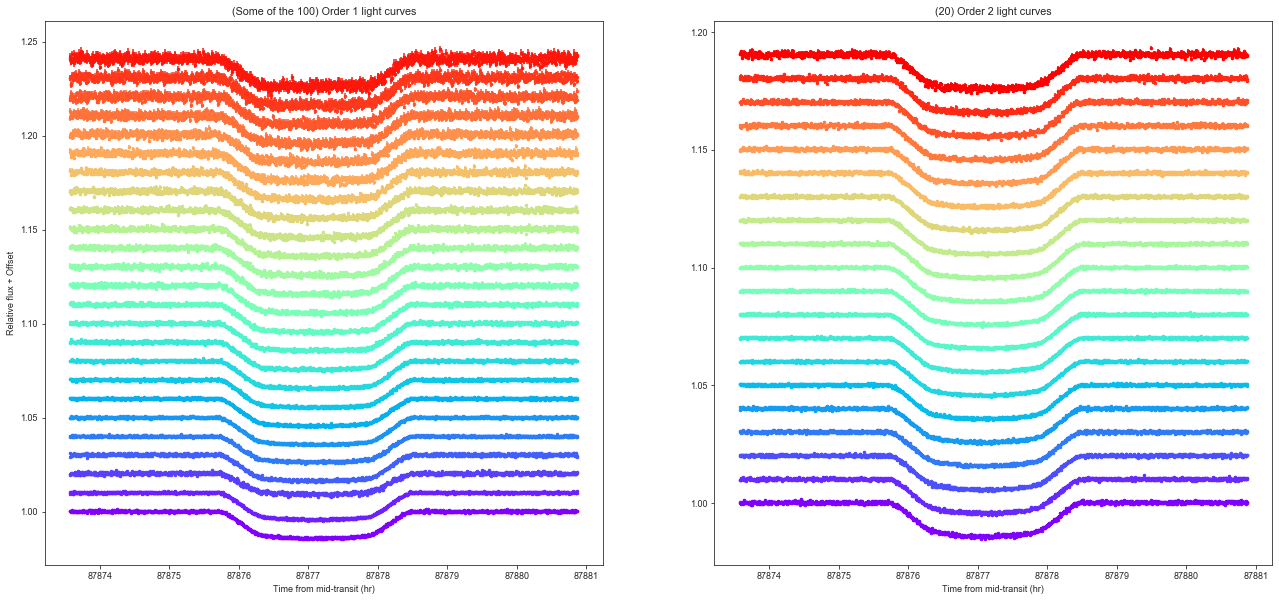

In [30]:
plt.figure(figsize=(22,10)) 
delta_w = 0.02

# Sum the fluxes on each of the bins. First for order 1:
counter = 0
plot_counter = 0
wbins = np.arange(np.min(spectra['order1']['w']),np.max(spectra['order1']['w']), delta_w)
color = plt.cm.rainbow(np.linspace(0,1,len(wbins)))
# Plot only a set of lightcurves to not overcrowd the plot:
idx_plot = np.arange(0,len(wbins),4)
plt.subplot(121)
for w,c in zip(wbins,color):
    spectra['order1']['wbin'+str(counter)] = {}
    spectra['order1']['wbin'+str(counter)]['w'] = w + delta_w*0.5
    spectra['order1']['wbin'+str(counter)]['wmin'] = w 
    spectra['order1']['wbin'+str(counter)]['wmax'] = w + delta_w
    idx = np.where((spectra['order1']['w']>w)&(spectra['order1']['w']<w+delta_w))[0]
    spectra['order1']['wbin'+str(counter)]['lc'] = np.sum(spectra['order1']['flux'][:,idx],axis=1)
    spectra['order1']['wbin'+str(counter)]['lc_errors'] = np.sqrt(np.sum(spectra['order1']['flux_errors'][:,idx]**2,axis=1))
    median_flux = np.median(spectra['order1']['wbin'+str(counter)]['lc'])
    spectra['order1']['wbin'+str(counter)]['lc'] = spectra['order1']['wbin'+str(counter)]['lc']/median_flux
    spectra['order1']['wbin'+str(counter)]['lc_errors'] = spectra['order1']['wbin'+str(counter)]['lc_errors']/median_flux
    if counter in idx_plot:
        plt.errorbar((spectra['times']-t0)*24,spectra['order1']['wbin'+str(counter)]['lc']+0.01*plot_counter,\
                     yerr = spectra['order1']['wbin'+str(counter)]['lc_errors'], fmt='.',color=c)
        #plt.text(4, 1.+0.01*plot_counter, r'{0:.2f}-{1:.2f} $\mu$m'.format(w,w+delta_w))
        plot_counter += 1
    counter += 1
spectra['order1']['nbins'] = counter
#plt.xlim(-4,5)
plt.xlabel('Time from mid-transit (hr)')
plt.ylabel('Relative flux + Offset')
plt.title('(Some of the {}) Order 1 light curves'.format(spectra['order1']['nbins']))

# And now for order 2:
counter = 0
wbins = np.arange(0.55,np.max(spectra['order2']['w']), delta_w)
color = plt.cm.rainbow(np.linspace(0,1,len(wbins)))
plt.subplot(122)
for w,c in zip(wbins,color):
    spectra['order2']['wbin'+str(counter)] = {}
    spectra['order2']['wbin'+str(counter)]['w'] = w + delta_w*0.5
    spectra['order2']['wbin'+str(counter)]['wmin'] = w 
    spectra['order2']['wbin'+str(counter)]['wmax'] = w + delta_w
    idx = np.where((spectra['order2']['w']>w)&(spectra['order2']['w']<w+delta_w))[0]
    spectra['order2']['wbin'+str(counter)]['lc'] = np.sum(spectra['order2']['flux'][:,idx],axis=1)
    spectra['order2']['wbin'+str(counter)]['lc_errors'] = np.sqrt(np.sum(spectra['order2']['flux_errors'][:,idx]**2,axis=1))
    median_flux = np.median(spectra['order2']['wbin'+str(counter)]['lc'])
    spectra['order2']['wbin'+str(counter)]['lc'] = spectra['order2']['wbin'+str(counter)]['lc']/median_flux
    spectra['order2']['wbin'+str(counter)]['lc_errors'] = spectra['order2']['wbin'+str(counter)]['lc_errors']/median_flux
    plt.errorbar((spectra['times']-t0)*24,spectra['order2']['wbin'+str(counter)]['lc']+0.01*counter,\
                     yerr = spectra['order2']['wbin'+str(counter)]['lc_errors'], fmt='.',color=c)
    #plt.text(4, 1.+0.005*counter, r'{0:.2f}-{1:.2f} $\mu$m'.format(w,w+delta_w))
    counter += 1
spectra['order2']['nbins'] = counter
plt.title('({}) Order 2 light curves'.format(spectra['order2']['nbins']))
#plt.xlim(-4,5)
plt.xlabel('Time from mid-transit (hr)')
#plt.ylabel('Relative flux')
plt.show()

2
wbin6: 0.9621975930687041 0.9821975930687041
wbin7: 0.9821975930687041 1.0021975930687042
wbin8: 1.0021975930687042 1.0221975930687042


array([1769., 1770., 1771., 1772., 1773., 1774., 1775., 1776., 1777.,
       1778., 1779., 1780., 1781., 1782., 1783., 1784., 1785., 1786.,
       1787., 1788., 1789., 1790., 1791., 1792., 1793., 1794., 1795.,
       1796., 1797., 1798., 1799., 1800., 1801., 1802., 1803., 1804.,
       1805., 1806., 1807., 1808., 1809., 1810., 1811., 1812., 1813.,
       1814., 1815., 1816., 1817., 1818., 1819., 1820., 1821., 1822.,
       1823., 1824., 1825., 1826., 1827., 1828., 1829., 1830., 1831.,
       1832., 1833., 1834., 1835., 1836., 1837., 1838., 1839., 1840.,
       1841., 1842., 1843., 1844., 1845., 1846., 1847., 1848., 1849.,
       1850., 1851., 1852., 1853., 1854., 1855., 1856., 1857., 1858.,
       1859., 1860., 1861., 1862., 1863., 1864., 1865., 1866., 1867.,
       1868., 1869., 1870., 1871., 1872., 1873., 1874., 1875., 1876.,
       1877., 1878., 1879., 1880., 1881., 1882., 1883., 1884., 1885.,
       1886., 1887., 1888., 1889., 1890., 1891., 1892., 1893., 1894.,
       1895., 1896.,

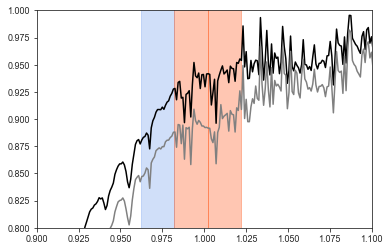

In [31]:
print(i)
y1 = chebyshev.chebval(X1[0,:],coeffs1[i,:])
cflux, cerror = aperture_extraction(corrected_data[i,:,:], X1[0,:], y1, 30, 50, error_image = errors[i,:,:])
nflux, nerror = aperture_extraction(corrected_data[i,:,:], X1[0,:], y1, 10, 50, error_image = errors[i,:,:],correct_bkg=False)
print('wbin6:',spectra['order1']['wbin6']['wmin'],spectra['order1']['wbin6']['wmax'])
print('wbin7:',spectra['order1']['wbin7']['wmin'],spectra['order1']['wbin7']['wmax'])
print('wbin8:',spectra['order1']['wbin8']['wmin'],spectra['order1']['wbin8']['wmax'])
plt.plot(spectra['order1']['w'], cflux/np.max(cflux), color = 'black')
plt.plot(spectra['order1']['w'], nflux/np.max(nflux), color = 'grey')
plt.fill_between([spectra['order1']['wbin6']['wmin'],spectra['order1']['wbin6']['wmax']],\
                 [0.,0.],[40000,40000],color='cornflowerblue',alpha=0.3)
plt.fill_between([spectra['order1']['wbin7']['wmin'],spectra['order1']['wbin7']['wmax']],\
                 [0.,0.],[40000,40000],color='orangered',alpha=0.3)
plt.fill_between([spectra['order1']['wbin8']['wmin'],spectra['order1']['wbin8']['wmax']],\
                 [0.,0.],[40000,40000],color='orangered',alpha=0.3)
plt.xlim([0.9,1.1])
plt.ylim([0.8,1.])
idx = np.where((spectra['order1']['w']>0.9) & (spectra['order1']['w']<1.1))[0]
spectra['order1']['x'][idx]

And now, let's fit those lightcurves. To this end, we once again use `juliet` --- however, we fix the ephemerides and orbital parameters ($P$, $t_0$, $a/R_*$ and $b$) to those found in the white-light analysis, as they should be wavelength-independant. In our fits, thus, we only leave the transit depth, the limb-darkening coefficients, the out-of-transit flux and the "jitter" as free parameters:

In [32]:
# Name of the parameters to be fit:

params = ['P_p1','t0_p1','a_p1','b_p1','q1_SOSS','q2_SOSS','ecc_p1','omega_p1',\
              'p_p1', 'mdilution_SOSS', 'mflux_SOSS', 'sigma_w_SOSS']

# Distributions:
dists = ['fixed','fixed','fixed','fixed','uniform','uniform','fixed','fixed',\
                 'normal', 'fixed', 'normal', 'loguniform']

# Hyperparameters
hyperps = [4.4652997979, 2459543.6955160568, 10.22, 0.750273, [0., 1.], [0., 1.], 0.0, 90.,\
                   [0.,0.2], 1.0, [0.,0.1], [0.1, 1000.]]

priors = juliet.generate_priors(params,dists,hyperps)

  analysing data from order1_wbin_0_juliet_results/jomnest_.txt
  analysing data from order1_wbin_1_juliet_results/jomnest_.txt
  analysing data from order1_wbin_2_juliet_results/jomnest_.txt
  analysing data from order1_wbin_3_juliet_results/jomnest_.txt
  analysing data from order1_wbin_4_juliet_results/jomnest_.txt
  analysing data from order1_wbin_5_juliet_results/jomnest_.txt
  analysing data from order1_wbin_6_juliet_results/jomnest_.txt
  analysing data from order1_wbin_7_juliet_results/jomnest_.txt
  analysing data from order1_wbin_8_juliet_results/jomnest_.txt
  analysing data from order1_wbin_9_juliet_results/jomnest_.txt
  analysing data from order1_wbin_10_juliet_results/jomnest_.txt
  analysing data from order1_wbin_11_juliet_results/jomnest_.txt
  analysing data from order1_wbin_12_juliet_results/jomnest_.txt
  analysing data from order1_wbin_13_juliet_results/jomnest_.txt
  analysing data from order1_wbin_14_juliet_results/jomnest_.txt
  analysing data from order1_wbin_1

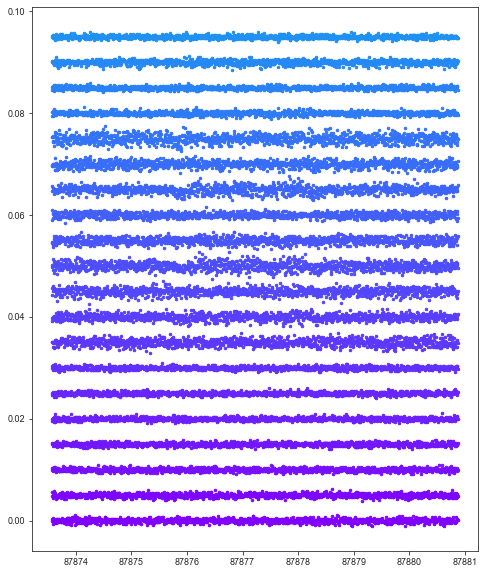

  analysing data from order2_wbin_0_juliet_results/jomnest_.txt
  analysing data from order2_wbin_1_juliet_results/jomnest_.txt
  analysing data from order2_wbin_2_juliet_results/jomnest_.txt
  analysing data from order2_wbin_3_juliet_results/jomnest_.txt
  analysing data from order2_wbin_4_juliet_results/jomnest_.txt
  analysing data from order2_wbin_5_juliet_results/jomnest_.txt
  analysing data from order2_wbin_6_juliet_results/jomnest_.txt
  analysing data from order2_wbin_7_juliet_results/jomnest_.txt
  analysing data from order2_wbin_8_juliet_results/jomnest_.txt
  analysing data from order2_wbin_9_juliet_results/jomnest_.txt
  analysing data from order2_wbin_10_juliet_results/jomnest_.txt
  analysing data from order2_wbin_11_juliet_results/jomnest_.txt
  analysing data from order2_wbin_12_juliet_results/jomnest_.txt
  analysing data from order2_wbin_13_juliet_results/jomnest_.txt
  analysing data from order2_wbin_14_juliet_results/jomnest_.txt
  analysing data from order2_wbin_1

In [33]:
plt.figure(figsize=(8,10)) 

for order in ['order1','order2']:
    spectra[order]['transmission_spectrum'] = {}
    spectra[order]['transmission_spectrum']['wavelengths'] = np.array([])
    spectra[order]['transmission_spectrum']['depths'] = np.array([])
    spectra[order]['transmission_spectrum']['errors']= np.array([])
    color = plt.cm.rainbow(np.linspace(0,1,spectra[order]['nbins']))
    counter = 0
    for i,c in zip(range(spectra[order]['nbins']),color):
        times, fluxes, fluxes_error, norm_times = {},{},{}, {}
        times['SOSS'], fluxes['SOSS'], fluxes_error['SOSS'] = spectra['times'],\
                                                          spectra[order]['wbin'+str(i)]['lc'],\
                                                          spectra[order]['wbin'+str(i)]['lc_errors']
    
        # Load and fit dataset with juliet (save them to order*_juliet_results):
        spectra[order]['dataset'] = juliet.load(priors=priors, t_lc = times, y_lc = fluxes,\
                                    yerr_lc = fluxes_error, out_folder = order+'_wbin_'+str(i)+'_juliet_results')

        spectra[order]['results'] = spectra[order]['dataset'].fit()

        # Save transmission spectrum for plotting later:
        spectra[order]['transmission_spectrum']['wavelengths'] = np.append(spectra[order]['transmission_spectrum']['wavelengths'],\
                                                                        spectra[order]['wbin'+str(i)]['w'])
        depths = ((spectra[order]['results'].posteriors['posterior_samples']['p_p1'])**2)*1e6
        spectra[order]['transmission_spectrum']['depths'] = np.append(spectra[order]['transmission_spectrum']['depths'],\
                                                                   np.median(depths))
        spectra[order]['transmission_spectrum']['errors'] = np.append(spectra[order]['transmission_spectrum']['errors'], \
                           np.sqrt(np.var(depths)))
        
        # Plot lightcurve fits:
        if counter < 20 and order == 'order1':
            plt.plot((spectra['times']-t0)*24,spectra[order]['wbin'+str(counter)]['lc']-\
                     spectra[order]['results'].lc.evaluate('SOSS')+0.005*counter,'.',color=c)
        counter += 1
    plt.show()
        

In [34]:
plt.figure(figsize=(20,5)) 

# Plot order 1 transit spectra:
plt.errorbar(spec['order1']['transmission_spectrum']['wavelengths'],\
             spec['order1']['transmission_spectrum']['depths'],\
             spec['order1']['transmission_spectrum']['errors'],\
             fmt='o',mfc='white',mec='orangered',ecolor='orangered',ms=10,elinewidth=1,label='NIRISS/SOSS Order 1')
# Same, order 2:
plt.errorbar(spec['order2']['transmission_spectrum']['wavelengths'],\
             spec['order2']['transmission_spectrum']['depths'],\
             spec['order2']['transmission_spectrum']['errors'],\
             fmt='o',mfc='white',mec='cornflowerblue',ecolor='cornflowerblue',ms=10,elinewidth=1,label='NIRISS/SOSS Order 2')

# HST data:
whst,rphst,rphst_err = np.loadtxt('hst.dat',unpack=True,usecols=(0,1,2))

depthhst,depthhst_err = np.zeros(len(whst)),np.zeros(len(whst))
for i in range(len(whst)):
    phst = np.random.normal(rphst[i],rphst_err[i],10000)
    dhst = (phst**2)*1e6
    depthhst[i],depthhst_err[i] = np.median(dhst),np.sqrt(np.var(dhst))

# Move HST data up to account from offset from JWST input model:
plt.errorbar(whst,depthhst+600,depthhst_err,fmt='s',color='black',ms=10,alpha=0.5,label='HST/WFC3 (Wakeford et al., 2013)')
wavelength_model, transit_depth_model = np.loadtxt('data/hp1_tspec.dat',unpack=True)
plt.plot(wavelength_model,transit_depth_model*1e6,color='black',lw=1)
plt.xlim(0.5,3.)
plt.ylim(14000,15000)
plt.ylabel('Transit depth (ppm)')
plt.xlabel('Wavelength ($\mu$m)')
plt.legend()
plt.show()
        

NameError: name 'spec' is not defined

<Figure size 1440x360 with 0 Axes>